## Installs

In [ ]:
!pip3 install twint
!pip3 install --user --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint
!pip install emoji
!pip install Arabic-Stopwords
!pip install stanza 
!pip install ar_wordcloud
!pip install ast
!pip install tqdm

## Imports


In [16]:
import pandas as pd 
import numpy as np
import re
import emoji
import nltk
nltk.download("stopwords")
import arabicstopwords.arabicstopwords as stp
from collections import Counter
import string
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import twint
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import stanza 
import ast
from tqdm import tqdm
import time
from bidi.algorithm import get_display
import networkx as nx
import arabic_reshaper
from ar_wordcloud import ArabicWordCloud
import nest_asyncio
nest_asyncio.apply()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Now we wil use Twinty to scrape the user tweets

In [3]:
def tweets_scrapping(user):
  try:
    g = twint.Config()
    g.Username = user
    g.Store_csv = True
    g.Output = user + '_tweets'

    twint.run.Search(g)

    df = pd.read_csv(f'/content/drive/MyDrive/dataset/{user}_tweets.csv')

    return df 
  except:
    print('Tweet scrapping has failed..Somthing went wrong')
    return None

## Tweet Cleansing

In [4]:
def deEmojify(text):
  regrex_pattern = re.compile(pattern = "["
      u"\U0001F600-\U0001F64F"  # emoticons
      u"\U0001F300-\U0001F5FF"  # symbols & pictographs
      u"\U0001F680-\U0001F6FF"  # transport & map symbols
      u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          "]+", flags = re.UNICODE)
  return regrex_pattern.sub(r'',text)

def remove_punctuations(text):
  arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
  english_punctuations = string.punctuation
  punctuations_list = arabic_punctuations + english_punctuations
  translator = str.maketrans('', '', punctuations_list)
  return text.translate(translator)
  
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [5]:
def tweet_cleaner(tweet, remove_english = True, remove_duaa = True, remove_emojis =True):
  tweet = re.sub('@[A-Za-z0-9]+', '', tweet)
  tweet = tweet.replace('_', '')
  tweet = re.sub('#[A-Za-z0-9]+', '', tweet)
  tweet = re.sub('#[ء-ي]+', '', tweet)

  # remove numbers
  tweet = re.sub('[0-9]', '', tweet)

  # Remove http link
  tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) 

  # remove engilsh words
  if remove_english:
    tweet = re.sub(r'[A-Za-z0-9]+', '', tweet) 

  # Remove arabic stopwords 
  tweet = ' '.join(c for c in tweet.split() if c not in stop_words)

  # Remove duaa
  if remove_duaa:
    tweet = ' '.join(word for word in tweet.split() if word not in duaa) 
  
  tweet = remove_punctuations(tweet)
  tweet = normalize_arabic(tweet)
  tweet = remove_repeating_char(tweet)
  if remove_emojis:
    tweet = re.sub(r'[^\w\s]', '', tweet)

  return tweet

In [6]:
def arabic_unneeded_words(stop_words_path, duaa_file_path):
  try:
    stop_words_file = open(stop_words_path, "r")
    duua_file =  open(duaa_file_path, "r")
  
    stop_words_content = stop_words_file.read()
    duaa_content = duua_file.read()

    arb_stopwords = stop_words_content.split()
    duaa = duaa_content.split()

    return arb_stopwords, duaa
  except:
    print('Somthing went wrong!.. check if the the files are valid')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### import dataset, stpwords and duaa file

In [8]:
# stop words and duaa 
stop_words, duaa = arabic_unneeded_words("/content/drive/MyDrive/Arabic Text Cleansing/Stopwords.txt", '/content/drive/MyDrive/Arabic Text Cleansing/duaa.txt')

# # we will add some new words that need to be removed
stop_words.extend(['بس', 'يعني', 'شيء', 'ايه', 'مب', 'الحين', 'لأن', 'لان', 'شاء', 'ان', 'ترا'])
duaa.extend(['نبينا', 'صل', 'وسلم', 'الحمدلله', 'بسم', 'الحمدالله', 'استغفر','أستغفر', 'استغفرالله', 'وبحمده'])

# tweets that we scrape, I did already scrape my tweets and named it as (tweets)
df = pd.read_csv('/content/drive/MyDrive/dataset/tweets.csv')
# or you can do this, if you face any errors just try run the scrape again and it will work, if not check your twint version
# df = tweets_scrapping(user)

In [9]:
df.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1385276859009675268,1385194144851795974,2021-04-22 16:58:35 UTC,2021-04-22,16:58:35,0,764426293,_itakida,Astronaut,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'emilya_sama', 'name': 'صايو'...",NaN,NaN,NaN,NaN
1,1385195906493030401,1385194144851795974,2021-04-22 11:36:54 UTC,2021-04-22,11:36:54,0,764426293,_itakida,Astronaut,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'iaxzf', 'name': 'الدُعزي', '...",NaN,NaN,NaN,NaN
2,1385194144851795974,1385194144851795974,2021-04-22 11:29:54 UTC,2021-04-22,11:29:54,0,764426293,_itakida,Astronaut,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,1384916085376487425,1384902436784062473,2021-04-21 17:04:59 UTC,2021-04-21,17:04:59,0,764426293,_itakida,Astronaut,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': '___mlk', 'name': 'MLeek', 'i...",NaN,NaN,NaN,NaN
4,1384915180501483523,1384902436784062473,2021-04-21 17:01:24 UTC,2021-04-21,17:01:24,0,764426293,_itakida,Astronaut,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': '___mlk', 'name': 'MLeek', 'i...",NaN,NaN,NaN,NaN


### We need to create some fields that we will use in the analysis

In [10]:
df['date'] = pd.to_datetime(df['date'], format= '%Y-%m-%d')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str)
df['quarter'] = df['date'].dt.quarter
df['year_quarter'] = df['year'].astype(str) + '-' + df['quarter'].astype(str) 

### General Visualization

In [48]:
# most active tweets 
pd.options.display.max_colwidth = 100
most_replied_tweet = df[df['replies_count'] == df['replies_count'].max()]['tweet'].values
most_retweeted_tweet = df[df['retweets_count'] == df['retweets_count'].max()]['tweet'].values
most_liked_tweet = df[df['likes_count'] == df['likes_count'].max()]['tweet'].values

print('Most replied tweet: {}\n********\nMost retweeted tweet: {}\n********\nMost liked tweet: {}'.format(most_replied_tweet, most_retweeted_tweet, most_liked_tweet))

Most replied tweet: ['هذه احسن 🌚 ايضًا بس الفولوينق  https://t.co/itx1QzmBKU']
********
Most retweeted tweet: ['اذا نظرت بزاوية مختلفة  http://t.co/No708vkdEu']
********
Most liked tweet: ['كيف تموت راينهارت وهو حاط الشيلد 😂😂 #PCshare  https://t.co/hr1tObGI5h']


In [53]:
# ------- preparing -----------

# getting most active quarter and hour
df['time_sliced'] = df['time'].astype(str).apply(lambda time: time[:2]).astype(int) # lambda x:x.value_counts().index[0]
most_active_year = df.groupby(['year_quarter', 'year', 'quarter'], as_index=False).agg({'tweet': 'count', 'time_sliced' : lambda x:x.value_counts().index[0]}).sort_values(by = ['year', 'quarter', 'time_sliced'])

# -------- Visualization ---------

# Creating the chart
fig = make_subplots(specs=[[{"secondary_y": True}]])

# first axis traces
fig.add_trace(
    go.Bar(x=most_active_year['year_quarter'], y=most_active_year['tweet'], name="عدد التغريدات"),
    secondary_y=False)

# second axis traces
fig.add_trace(
    go.Scatter(x=most_active_year['year_quarter'], y=most_active_year['time_sliced'].astype(int), name="الساعة"),
    secondary_y=True)

# Add figure title
fig.update_layout(
    title_text="عدد التغريدات واكثر الساعات تغريدا لكل ربع",
    hovermode = 'x unified')

# Set x-axis title
fig.update_xaxes(title_text="الربع من كل سنة", type ='category')

# Set y-axes titles
fig.update_yaxes(title_text="عدد التغريدات", secondary_y=False, showgrid = False)
fig.update_yaxes(title_text="الساعة الاكثر تفاعلا", secondary_y=True, showgrid = False)


fig.show()

In [50]:
# ------- preparing -----------

df['reply_to_eval'] = df['reply_to'].apply(lambda row: eval(row))
mentions = []
for year in df['year'].unique():
  df_year = df[df['year'] == year]
  for row in df_year['reply_to_eval']: 
    if len(row) != 0:
      for mention in row:
        mentions.append((mention['screen_name'], year))
df_active_user = pd.DataFrame(mentions, columns=['mention', 'year'])

# -------- Visualization ---------

df_grouped = df_active_user.groupby(['year', 'mention'], as_index=False).agg(mentions_count =('mention', 'count'))
df_grouped['RN'] = df_grouped.groupby(['year'])['mentions_count'].rank(ascending=False).astype(int)
df_grouped.sort_values(by='RN', inplace=True)
df_grouped = df_grouped.groupby(['year'], as_index=False).head(3)
df_grouped['RN'] = df_grouped['RN'].replace({1:'الأول', 2:'الثاني', 3:'الثالث'})

fig = go.Figure(data=[go.Bar(
    name = 'الأول',
    x = df_grouped[df_grouped['RN']== 'الأول']['year'],
    y = df_grouped[df_grouped['RN']== 'الأول']['mentions_count'],
    text = df_grouped[df_grouped['RN']== 'الأول']['mention'],
    textposition ='outside',
    marker_color = px.colors.sequential.Plasma_r[2]
  ),
                      go.Bar(
    name = 'الثاني',
    x = df_grouped[df_grouped['RN']== 'الثاني']['year'],
    y = df_grouped[df_grouped['RN']== 'الثاني']['mentions_count'],
    text = df_grouped[df_grouped['RN']== 'الثاني']['mention'],
    textposition ='outside',
    marker_color = px.colors.sequential.Plasma_r[5]
  ),
                      go.Bar(
    name = 'الثالث',
    x = df_grouped[df_grouped['RN']== 'الثالث']['year'],
    y = df_grouped[df_grouped['RN']== 'الثالث']['mentions_count'],
    text = df_grouped[df_grouped['RN']== 'الثالث']['mention'],
    textposition ='outside',
    marker_color = px.colors.sequential.Plasma_r[-1]
  )
])
fig.show()

### before we feed the tweets to tnext analysis, we need to clean the text so we can get the best of it.

In [11]:
# we will see what the cleanning function do
test_text = '@some_user توقعي لمباراة اليوم فوز فريق الهلاااااال وبفارق قوي جدا #فوز_الهلال ان شاء الله بيكون قيم سهههههل #الهلال_بيفوز !!!!!! وهذا لينك لرابط المباراة https://stackoverflow.com/questions/13730468/from-nd-to-1d-arrays'

tweet_cleaner(test_text)

'توقعي لمباراه فوز فريق الهلال وبفارق قوي بيكون قيم سهل لينك لرابط المباراه'

In [12]:
df['cleaned_tweet'] = df['tweet'].apply(tweet_cleaner)

In [16]:
# getting all the words for each year
def words_per_year(df):
  years = df['year'].unique()
  words_per_year = dict.fromkeys(years)
  for year in years:
    df_year = df[df['year'] == year]
    u = df_year.cleaned_tweet.str.split(expand=True).stack()
    words_per_year[year] = u.values

  return words_per_year

In [17]:
def most_frequent_words(words, freq_num):
  words_to_count = (word for word in words if word[:1])
  c = Counter(words_to_count)
  return c.most_common(freq_num)

In [18]:
# ------- preparing -----------
# getting all the words for each year 
words_dict = words_per_year(df)

# creating data frame that have the years in hte columns to feed it the most frequent words
vocab_df = pd.DataFrame(columns=df.year.unique())
vocab_years = vocab_df.columns

# chosing the number of most frequent words, we will go with the most 10 words
number_of_words = 10

for col in vocab_df.columns:
  vocabs = most_frequent_words(words_dict[col], number_of_words)
  values = []
  freq = []
  for word in vocabs:
    values.append(word[0])
  vocab_df[col] = values

# -------- Visualization ---------
fig_table = go.Figure(data= [go.Table(
      header=dict(values=list(vocab_years),
                fill_color='paleturquoise',
                align='center'),

      cells=dict(values=[vocab_df[year] for year in vocab_years],
              fill_color='lavender',
              align='center')
)])

fig_table.show()

In [13]:
# download Arabic model
stanza.download('ar') 
# initialize Arabic neural pipeline
nlp = stanza.Pipeline('ar', processors='tokenize,pos, ner', use_gpu=True) 

2022-03-04 17:47:33 INFO: Downloading default packages for language: ar (Arabic)...


2022-03-04 17:47:46 INFO: Finished downloading models and saved to /root/stanza_resources.
2022-03-04 17:47:46 WARNING: Language ar package default expects mwt, which has been added
2022-03-04 17:47:46 INFO: Loading these models for language: ar (Arabic):
| Processor | Package |
-----------------------
| tokenize  | padt    |
| mwt       | padt    |
| pos       | padt    |
| ner       | aqmar   |

2022-03-04 17:47:46 INFO: Use device: cpu
2022-03-04 17:47:46 INFO: Loading: tokenize
2022-03-04 17:47:47 INFO: Loading: mwt
2022-03-04 17:47:47 INFO: Loading: pos
2022-03-04 17:47:47 INFO: Loading: ner
2022-03-04 17:47:48 INFO: Done loading processors!


In [14]:
def relation_extraction(nlp_tweet, tweet):
  tmp_list = []
  tweet_words = tweet.split()
  # getting all the words in the tweet with there pos's
  words_nlp = [[word for word in sent.words] for sent in nlp_tweet.sentences]

  for entity in nlp_tweet.entities:
    # only get the first word from each entity 
    entity_first_word = entity.text.split()[0]

    # getting the previus entity word index from the splitted tweet then access the nlp_tweet to get the text and pos
    word_before_ent = (words_nlp[0][tweet_words.index(entity_first_word) - 1].text, words_nlp[0][tweet_words.index(entity_first_word) - 1].upos)

    # check if the pos of the previus word is Verb or Adj 
    if word_before_ent[1] == 'VERB' or word_before_ent[1] == 'ADJ':

      # appending to list so we can return whole list of relations 
      tmp_list.append((word_before_ent[0], entity.text))

  return tmp_list

  0%|          | 2/27602 [00:00<1:15:59,  6.05it/s]/usr/local/lib/python3.7/dist-packages/stanza/models/common/beam.py:86: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  prevK = bestScoresId // numWords
100%|██████████| 27602/27602 [1:00:31<00:00,  7.60it/s]


downloading and unzipping arabic font: /usr/local/lib/python3.7/dist-packages/ar_wordcloud/fonts/NotoNaskhArabic-unhinted.zip .. 
downloading and unzipping arabic font: /usr/local/lib/python3.7/dist-packages/ar_wordcloud/fonts/NotoSansArabic-unhinted.zip .. 
downloading and unzipping arabic font: /usr/local/lib/python3.7/dist-packages/ar_wordcloud/fonts/NotoKufiArabic-unhinted.zip .. 


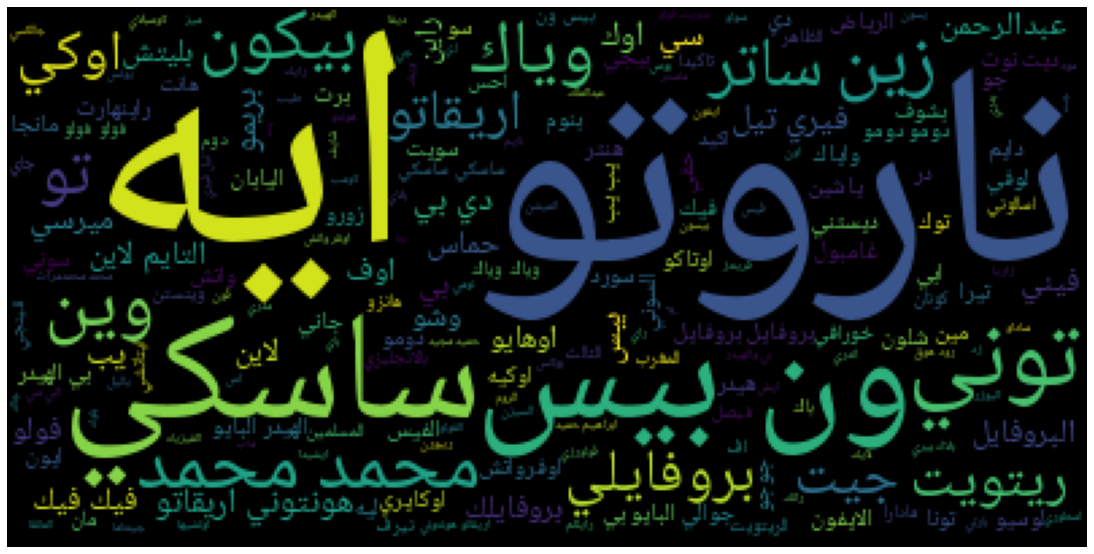

In [15]:
# creating the entities form each tweet
entites = []
knowledge = []
for tweet in tqdm(df['cleaned_tweet']):
  # getting all entities for each tweet
  nlp_tweet = nlp(tweet) 
  for ent in nlp_tweet.entities:
    entites.append(ent.text)

  # getting the realtion and feed it to the knwledge list we have 
  knowledge.extend(relation_extraction(nlp_tweet, tweet))

NER_Entities = ' '.join(entites)

# arabic word cloud wrapper
awc = ArabicWordCloud(background_color="black")

wc = awc.from_text(NER_Entities)

plt.figure(figsize = (15, 15), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)